### Seperate concepts extracted from ArtEmis based on the scores of:
    - Concreteness, 
    - Subjectivity based on TextBlob 
    - Sentimenet-Analysis based on (nltk) Vader

In [2]:
import nltk
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pylab as plt
from functools import partial
from ast import literal_eval
from nltk.sentiment.vader import SentimentIntensityAnalyzer


from data_analysis.utils import contains_word, contains_bigrams, concreteness_of_sentence, pos_analysis

sns.set()

%load_ext autoreload
%autoreload 2

In [2]:
try:
    from textblob import TextBlob    
except:
    print('For analyzing the subjectivity need to install textblob')  
    print('e.g., conda install -c conda-forge textblob')

In [81]:
freq_file = '../../data/symspell_frequency_dictionary_en_82_765.txt'
glove_file = '../../data/glove.6B.100d.vocabulary.txt'

## Use your path:
subset_data_csv = '/Users/Cherry0904/Desktop/subset_2000_concepts.csv'
# trial_data_csv = '/Users/Cherry0904/Desktop/3000_old_g_145_p_2_0.9.csv'
still_life_csv = '/Users/Cherry0904/Desktop/16000_still_life_grouping_with_new_hyperparameters.csv'

In [4]:
# Load the dataset for concreteness score
brm_file=\
'/Users/Cherry0904/Desktop/official_data/Concreteness_ratings_Brysbaert_et_al_BRM.xlsx'


In [5]:
load_ela = True
load_still_life = False
brm_drop_articles = True # use or not the: "the", "a", "an", "every".
spell_check_non_artemis_data = False

In [82]:
### Load the artemis dataset
datasets = dict()
if load_ela:
    df = pd.read_csv(subset_data_csv)
    df.tokens = df.text.apply(lambda x: x.split())
    df.tokens_len = df.tokens.apply(lambda x: len(x))
    # df.tokens = df.tokens.apply(literal_eval)
    datasets['subset_2000'] = df

if load_still_life:
    df = pd.read_csv(still_life_csv)
    df.tokens = df.text.apply(lambda x: x.split())
    df.tokens_len = df.tokens.apply(lambda x: len(x))
    # df.tokens = df.tokens.apply(literal_eval)
    datasets['16000_still_life'] = df

/var/folders/6f/6ngp6cds4hq9z7fnmw29_d2m0000gn/T/ipykernel_59259/2020660900.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.tokens = df.text.apply(lambda x: x.split())
/var/folders/6f/6ngp6cds4hq9z7fnmw29_d2m0000gn/T/ipykernel_59259/2020660900.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.tokens_len = df.tokens.apply(lambda x: len(x))


In [83]:
for k, v in datasets.items():
    print(k, 'N-sentences:', len(v), 'Average Length:', v.tokens_len.mean())

subset_2000 N-sentences: 347 Average Length: 5.008645533141211


In [84]:
pd.set_option('display.max_rows', 500)

#### Concreteness Analysis

In [85]:
#
# Load "concreteness and abstractness" values
#

## Note. If your pandas cannot read excel do:
## else:  pip install xlrd==1.2.0

brm_data = pd.read_excel(brm_file)
brm_data.Word = brm_data.Word.apply(lambda x: str(x).lower())

if brm_drop_articles:
    brm_data = brm_data[brm_data.Dom_Pos != 'Article']
    
brm_data = brm_data[['Word', 'Conc.M']]
brm_data.columns = ['word', 'concreteness']
word_to_concreteness = dict(zip(brm_data.word, brm_data.concreteness))

In [86]:
concreteness_scores = dict()
for dset_name in datasets:    
    concreteness_scores[dset_name] = datasets[dset_name].tokens.apply(lambda x: concreteness_of_sentence(x, word_to_concreteness))    
    smean = concreteness_scores[dset_name].mean()
    smedian = concreteness_scores[dset_name].median()
    print(dset_name, 'concreteness', smean, smedian)

subset_2000 concreteness 2.93397054536226 2.8133333333333335


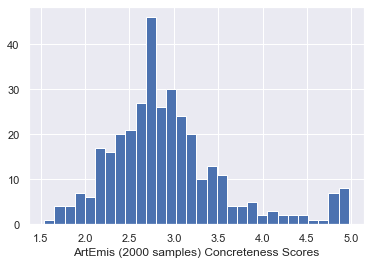

In [88]:
plt.hist(concreteness_scores['subset_2000'], bins=30)
plt.xlabel('ArtEmis (2000 samples) Concreteness Scores')
plt.show()

In [89]:
# restrict to the most abstract words, bigrams (per percentile value). How many of those are precent in eaach dataset?
wc_vals = list(word_to_concreteness.values())
prc = 1
conc_threshold = np.percentile(wc_vals, prc)
abstract_unigrams = set()
abstract_bigrams = set()
for k, v in word_to_concreteness.items():
    if v <= conc_threshold:
        if ' ' in k:
            abstract_bigrams.add(k)
        else:
            abstract_unigrams.add(k)            

print('Percentile of most abstract:', prc)
print('Number of words/bigrams to be used as abstract:', len(abstract_unigrams), len(abstract_bigrams))

uses_abstract = contains_word(datasets['subset_2000'], abstract_unigrams)
uses_abstract |= datasets['subset_2000'].tokens.apply(partial(contains_bigrams, abstract_bigrams))
print(uses_abstract.mean())

Percentile of most abstract: 1
Number of words/bigrams to be used as abstract: 424 4
0.0


#### Sentiment Analysis

In [90]:
# Pretrained transformer for sentiment analysis
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")
sentiment_pipeline(["me feel sad"])[0]['score']
transformer_sentiment_scores = dict()


In [91]:
# Vader sentiment scores
def vader_classify(score, threshold=0.05):
    if abs(score) < threshold:
        return 'neutral'

    if score > 0:
        return 'positive'

    if score < 0:
        return 'negative'
    
def vader_score(sentence):
    return vader.polarity_scores(sentence)['compound']

In [92]:
nltk.download('vader_lexicon')
sentiment_scores = dict()
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/Cherry0904/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [93]:
# Poor predictions
print(vader.polarity_scores('me feel content')['compound'])
print(TextBlob('me feel content').sentiment.subjectivity)

0.0
0.0


In [94]:
# Flair sentiment scores
from flair.models import TextClassifier
from flair.data import Sentence

classifier = TextClassifier.load('en-sentiment')
def sentiment_predict(sentence):
    """ Predict the sentiment of a sentence using the Flair library"""
    text = Sentence(sentence)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = text.to_dict()['all labels'][0]['confidence']
    else:
        result = -(text.to_dict()['all labels'][0]['confidence'])
    return round(result, 3)

2022-08-09 16:46:37,369 loading file /Users/Cherry0904/.flair/models/sentiment-en-mix-distillbert_4.pt


In [95]:
# If use Vader
for dset_name in datasets:    
    sentiment_scores[dset_name] = datasets[dset_name]['text'].apply(lambda x: vader.polarity_scores(x)['compound'])
    scores = sentiment_scores[dset_name]
    smean = scores.abs().mean()
    smedian = scores.abs().median() 
    print(dset_name, 'sentiment-score', smean, smedian)

subset_2000 sentiment-score 0.24856916426512968 0.1027


In [96]:
# If use transformer
for dset_name in datasets:    
    transformer_sentiment_scores[dset_name] = datasets[dset_name]['text'].apply(lambda x: sentiment_pipeline(x)[0]['score'])
    scores = transformer_sentiment_scores[dset_name]
    smean = scores.abs().mean()
    smedian = scores.abs().median() 
    print(dset_name, 'transformer_sentiment-score', smean, smedian)
    

subset_2000 transformer_sentiment-score 0.9780097471534004 0.999147891998291


In [97]:
sentiment_classes_list = []  # aggregate for all datasets to make a nice plot
dataset_names = []
sentiment_classes = dict()
threshold = 0.05
for name in sentiment_scores:
    temp = sentiment_scores[name].apply(lambda x: vader_classify(x, threshold=threshold))
    sentiment_classes[name] = temp    
    sentiment_classes_list.extend(temp.to_list())
    dataset_names.extend(len(temp) * [name])    

In [98]:
for name in sentiment_classes:
    print(name, (sentiment_classes[name] == 'neutral').mean())

subset_2000 0.4899135446685879


In [99]:
d1 = pd.DataFrame(dataset_names, columns=['dataset'])
d2 = pd.DataFrame(sentiment_classes_list, columns=['sentiment-class'])
aggregate_sentiment_stats = pd.concat([d1, d2], axis=1)

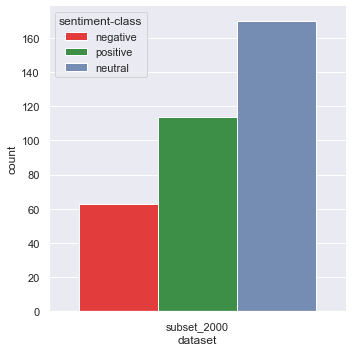

In [100]:
c = sns.catplot(x="dataset", 
                hue="sentiment-class", 
                data=aggregate_sentiment_stats, 
                kind="count",                 
                palette={"negative": "#FE2020", 
                         "positive": "#2f9c3b", 
                         "neutral": "#6b8abd"},                                
                legend_out=False,
               )
plt.show()

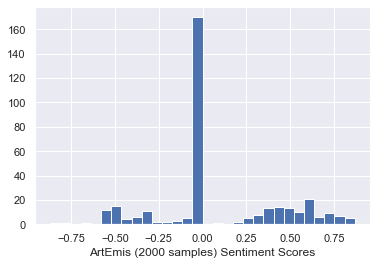

In [101]:
plt.hist(sentiment_scores['subset_2000'], bins=30)
plt.xlabel('ArtEmis (2000 samples) Sentiment Scores')
plt.show()

#### Subjectivity Analysis

In [102]:
def subjectivity(utterance):
    testimonial = TextBlob(utterance)
    return testimonial.sentiment.subjectivity

In [25]:
print(TextBlob('The painting is white').sentiment.subjectivity)
print(TextBlob('The painting is nice').sentiment.subjectivity)

0.0
1.0


In [103]:
subjectivity_scores = dict()
for dset_name in datasets:    
    # subjectivity_scores[dset_name] = df_parallel_column_apply(datasets[dset_name], subjectivity, 'text')
    subjectivity_scores[dset_name] = datasets[dset_name]['text'].apply(lambda x: subjectivity(x))


In [104]:
print(subjectivity_scores['subset_2000'].mean())
print(subjectivity_scores['subset_2000'].median())

0.34632576277388954
0.2


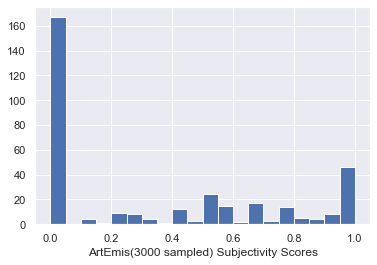

In [105]:
plt.hist(subjectivity_scores['subset_2000'], bins=20)
plt.xlabel('ArtEmis(3000 sampled) Subjectivity Scores')
plt.show()

#### Concept Separation

In [106]:
# Produce a dataframe with all three scores
df_with_scores = df[['freq', 'text']]
# df_with_scores['concreteness_score'] = concreteness_scores['16000_still_life']
# df_with_scores['sentiment_score'] = sentiment_scores['16000_still_life']
# df_with_scores['subjectivity_score'] = subjectivity_scores['16000_still_life']
df_with_scores['concreteness_score'] = concreteness_scores['subset_2000']
df_with_scores['sentiment_score'] = sentiment_scores['subset_2000']
df_with_scores['subjectivity_score'] = subjectivity_scores['subset_2000']
df_with_scores['transformer_sentiment_score'] = transformer_sentiment_scores['subset_2000']
print(df_with_scores)

     freq                                               text  \
0     156                                        me feel sad   
1     121                                       me feel calm   
2      24                                 which is hilarious   
3      17                                     that annoys me   
4      20                                   me feel confused   
5      17                                           me laugh   
6      10                                    me feel excited   
7       6                                  me feel disgusted   
8      90                                    the colors used   
9      11                                     the man's head   
10     32                                    it is beautiful   
11     12                             this painting portrays   
12      7                                       it is boring   
13      5                                     which is gross   
14     19                    i love all 

/var/folders/6f/6ngp6cds4hq9z7fnmw29_d2m0000gn/T/ipykernel_59259/1997487572.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_scores['concreteness_score'] = concreteness_scores['subset_2000']
/var/folders/6f/6ngp6cds4hq9z7fnmw29_d2m0000gn/T/ipykernel_59259/1997487572.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_scores['sentiment_score'] = sentiment_scores['subset_2000']


#### Separation rules (based on three types of scores)

In [113]:
# Estabilish some threshold of concreteness, subjectivity and sentiment scores to separate "real" and "abstract/emotional" concepts
# Concrete concepts
concrete_concepts = df_with_scores.loc[(np.abs(df_with_scores['sentiment_score']) < 0.05) & (df_with_scores['subjectivity_score'] < 0.1) & (df_with_scores['transformer_sentiment_score'] <= 0.98)]
# more_concrete_concepts = df_with_scores.loc[(df_with_scores['concreteness_score'] >= 2.5) & ((np.abs(df_with_scores['sentiment_score']) > 0.05) | (df_with_scores['subjectivity_score'] > 0.1) | (df_with_scores['transformer_sentiment_score'] > 0.995))]
more_concrete_concepts = df_with_scores.loc[(df_with_scores['concreteness_score'] > 3.1) & (np.abs(df_with_scores['sentiment_score']) < 0.1) & (df_with_scores['subjectivity_score'] < 0.1) & (df_with_scores['transformer_sentiment_score'] > 0.98)]
all_concrete_concepts = concrete_concepts.append(more_concrete_concepts, ignore_index=False)
# Sort rows by index values
all_concrete_concepts = all_concrete_concepts.sort_index(ascending=True)
all_concrete_concepts.loc[:]
# more_concrete_concepts.loc[:]

/var/folders/6f/6ngp6cds4hq9z7fnmw29_d2m0000gn/T/ipykernel_59259/2450609048.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_concrete_concepts = concrete_concepts.append(more_concrete_concepts, ignore_index=False)


,freq,text,concreteness_score,sentiment_score,subjectivity_score,transformer_sentiment_score
8,90,the colors used,3.405000,0.0,0.0,0.996964
9,11,the man's head,4.750000,0.0,0.0,0.781082
11,12,this painting portrays,3.365000,0.0,0.0,0.998381
16,28,the man's face,4.870000,0.0,0.0,0.954891
22,26,the woman's face,4.870000,0.0,0.0,0.983903
24,8,i look at this painting,3.138000,0.0,0.0,0.998763
33,7,what is going on,2.382500,0.0,0.0,0.969637
37,9,the man's expression,2.540000,0.0,0.0,0.977643
39,3,me feel,3.305000,0.0,0.0,0.992897
47,5,people are dancing,3.693333,0.0,0.0,0.999076


In [114]:
# Abstract concepst - around 10 errors in 100 examples - plenty of "he is", "it is", "he's looking at" - low concrete scores
abstract_concepts = df_with_scores[~df_with_scores.index.isin(all_concrete_concepts.index)] # ~ means notin
abstract_concepts.loc[:]

,freq,text,concreteness_score,sentiment_score,subjectivity_score,transformer_sentiment_score
0,156,me feel sad,3.226667,-0.4767,1.000000,0.998829
1,121,me feel calm,3.146667,0.3182,0.750000,0.901592
2,24,which is hilarious,1.840000,0.4019,1.000000,0.999883
3,17,that annoys me,2.935000,-0.4215,0.000000,0.993738
4,20,me feel confused,2.980000,-0.3182,0.700000,0.998177
5,17,me laugh,4.270000,0.5574,0.100000,0.999790
6,10,me feel excited,2.976667,0.3400,0.750000,0.999747
7,6,me feel disgusted,2.983333,-0.5267,1.000000,0.999714
10,32,it is beautiful,2.186667,0.5994,1.000000,0.999886
12,7,it is boring,2.156667,-0.3182,1.000000,0.999783


In [ ]:
df_with_scores.loc[(np.abs(df_with_scores['sentiment_score']) > 0.05) | (df_with_scores['subjectivity_score'] > 0.1) | (df_with_scores['transformer_sentiment_score'] > 0.995)]

In [117]:
# Estabilish some threshold of concreteness, subjectivity and sentiment scores to separate "real" and "abstract/emotional" concepts
# Concrete concepts
df_with_scores.loc[(np.abs(df_with_scores['sentiment_score']) <= 0.05) & (df_with_scores['concreteness_score'] >= 3.2) & (df_with_scores['subjectivity_score'] <= 0.1) & (df_with_scores['transformer_sentiment_score'] <= 0.995) | (df_with_scores['concreteness_score'] >= 4.5)]

,freq,text,concreteness_score,sentiment_score,subjectivity_score,transformer_sentiment_score
12,4,the red reminds me of blood,3.775000,0.0,0.0,0.659286
14,4,the woman's dress,4.930000,0.0,0.0,0.959212
23,13,the woman's face,4.870000,0.0,0.0,0.983903
25,7,the man's face,4.870000,0.0,0.0,0.954891
27,4,the man's eyes,4.850000,0.0,0.0,0.995839
32,2,horse drawn,3.895000,0.0,0.0,0.969658
51,2,the womans face,4.870000,0.0,0.0,0.991646
52,2,baby's face,4.870000,0.0,0.0,0.998025
53,3,a lot going on,3.213333,0.0,0.0,0.986237
54,4,the woman's outfit,4.120000,0.0,0.0,0.988418


In [108]:
# Emotional/abstract concepts (contain "me", "I" etc.)
df_with_scores.loc[(df_with_scores['concreteness_score'] < 4.5) & ((np.abs(df_with_scores['sentiment_score']) > 0.05) | (df_with_scores['concreteness_score'] < 3.2) | (df_with_scores['subjectivity_score'] > 0.1) | (df_with_scores['transformer_sentiment_score'] > 0.996))]

,freq,text,concreteness_score,sentiment_score,subjectivity_score,transformer_sentiment_score
0,20,me feel sad,3.226667,-0.4767,1.000000,0.998829
1,32,me feel calm,3.146667,0.3182,0.750000,0.901592
2,6,me feel excited,2.976667,0.3400,0.750000,0.999747
3,7,me laugh,4.270000,0.5574,0.100000,0.999790
4,9,the colors are beautiful and calming peaceful...,2.461250,0.9287,0.833333,0.999883
5,6,her look upset,2.790000,-0.3818,0.000000,0.998483
6,6,the colors aren't attractive,3.405000,-0.3412,1.000000,0.999776
7,13,the light in the painting brings a sense of p...,2.950000,0.5423,0.700000,0.999873
8,5,me feel scared,3.036667,-0.4404,0.000000,0.994808
9,5,me feel awe,2.833333,0.0000,0.000000,0.999617


In [ ]:
# Emotional/abstract concepts
df_with_scores.loc[(np.abs(df_with_scores['sentiment_score']) > 0.05) | (df_with_scores['concreteness_score'] < 2.5) | (df_with_scores['subjectivity_score'] > 0.1) & (df_with_scores['transformer_sentiment_score'] > 0.995)]

In [119]:
# Create a new column to indicate whether the extracted concept is concrete/subjective
concrete_condition = (np.abs(df_with_scores['sentiment_score']) < 0.05) & (df_with_scores['subjectivity_score'] < 0.1) & (df_with_scores['transformer_sentiment_score'] <= 0.98)
another_concrete_condition = (df_with_scores['concreteness_score'] > 3.1) & (np.abs(df_with_scores['sentiment_score']) < 0.05) & (df_with_scores['subjectivity_score'] < 0.1) & (df_with_scores['transformer_sentiment_score'] > 0.98)

def f(row):
    if (np.abs(row['sentiment_score']) < 0.05) & (row['subjectivity_score'] < 0.1) & (row['transformer_sentiment_score'] <= 0.98):
        val = 'concrete'
    elif (row['concreteness_score'] > 3.1) & (np.abs(row['sentiment_score']) < 0.05) & (row['subjectivity_score'] < 0.1) & (row['transformer_sentiment_score'] > 0.98):
        val = 'concrete'
    elif "me " in row['text'] or "i " in row['text'] or "i'm " in row['text']:
        val = 'affective'
    else:
        val = 'perceptive'
    return val

df_with_scores['predicted_concept_label'] = df_with_scores.apply(f, axis=1)
df_with_scores['true_concept_label'] = df_with_scores.apply(f, axis=1)



In [149]:
df_with_scores.to_csv('/Users/Cherry0904/Desktop/subset_2000_concepts_with_labels.csv', sep=',', encoding='utf-8')

### Analysis of concept groups

In [3]:
df_with_scores = pd.read_csv('/Users/Cherry0904/Desktop/subset_2000_concepts_with_labels.csv')
df_with_scores['predicted_concept_label'].value_counts() 

perceptive    223
concrete       72
affective      52
Name: predicted_concept_label, dtype: int64

In [18]:
print(df_with_scores)

     Unnamed: 0  freq                           text  concreteness_score  \
0             0   156                    me feel sad            3.226667   
1             1   121                   me feel calm            3.146667   
2             2    24             which is hilarious            1.840000   
3             3    17                 that annoys me            2.935000   
4             4    20               me feel confused            2.980000   
..          ...   ...                            ...                 ...   
342         342     2           the colors are angry            2.886667   
343         343     3            the sky is gorgeous            2.763333   
344         344     2   the landscape looks peaceful            3.103333   
345         345     3          the blues are calming            2.135000   
346         346     2                    i was young            2.926667   

     sentiment_score  subjectivity_score  transformer_sentiment_score  \
0            -

In [4]:
dff = df_with_scores.groupby(["predicted_concept_label"]).freq.sum().reset_index()
print(dff)

  predicted_concept_label  freq
0               affective   562
1                concrete   368
2              perceptive   745


In [146]:
# The average freq of all concepts
(562+368+745)/(223+72+52)

4.827089337175792

In [15]:
# Check the shannon entrophy for the entire artemis dataset 
list_of_counts = [10, 72, 223, 52]
list_of_averaged_nums_of_one = [214/9, 368/72, 745/223, 562/52] # concrete, perceptive, affective
# Check the averaged concept freq for each concept group
print(list_of_averaged_nums_of_one)
total_count = sum(list_of_averaged_nums_of_one)
shannon_entropy = -(sum([c/total_count * np.log(c/total_count) for c in list_of_averaged_nums_of_one]))/np.log(3)
print(shannon_entropy)
# print(list_of_counts)

[23.77777777777778, 5.111111111111111, 3.3408071748878925, 10.807692307692308]
1.0251513294742702


<BarContainer object of 4 artists>

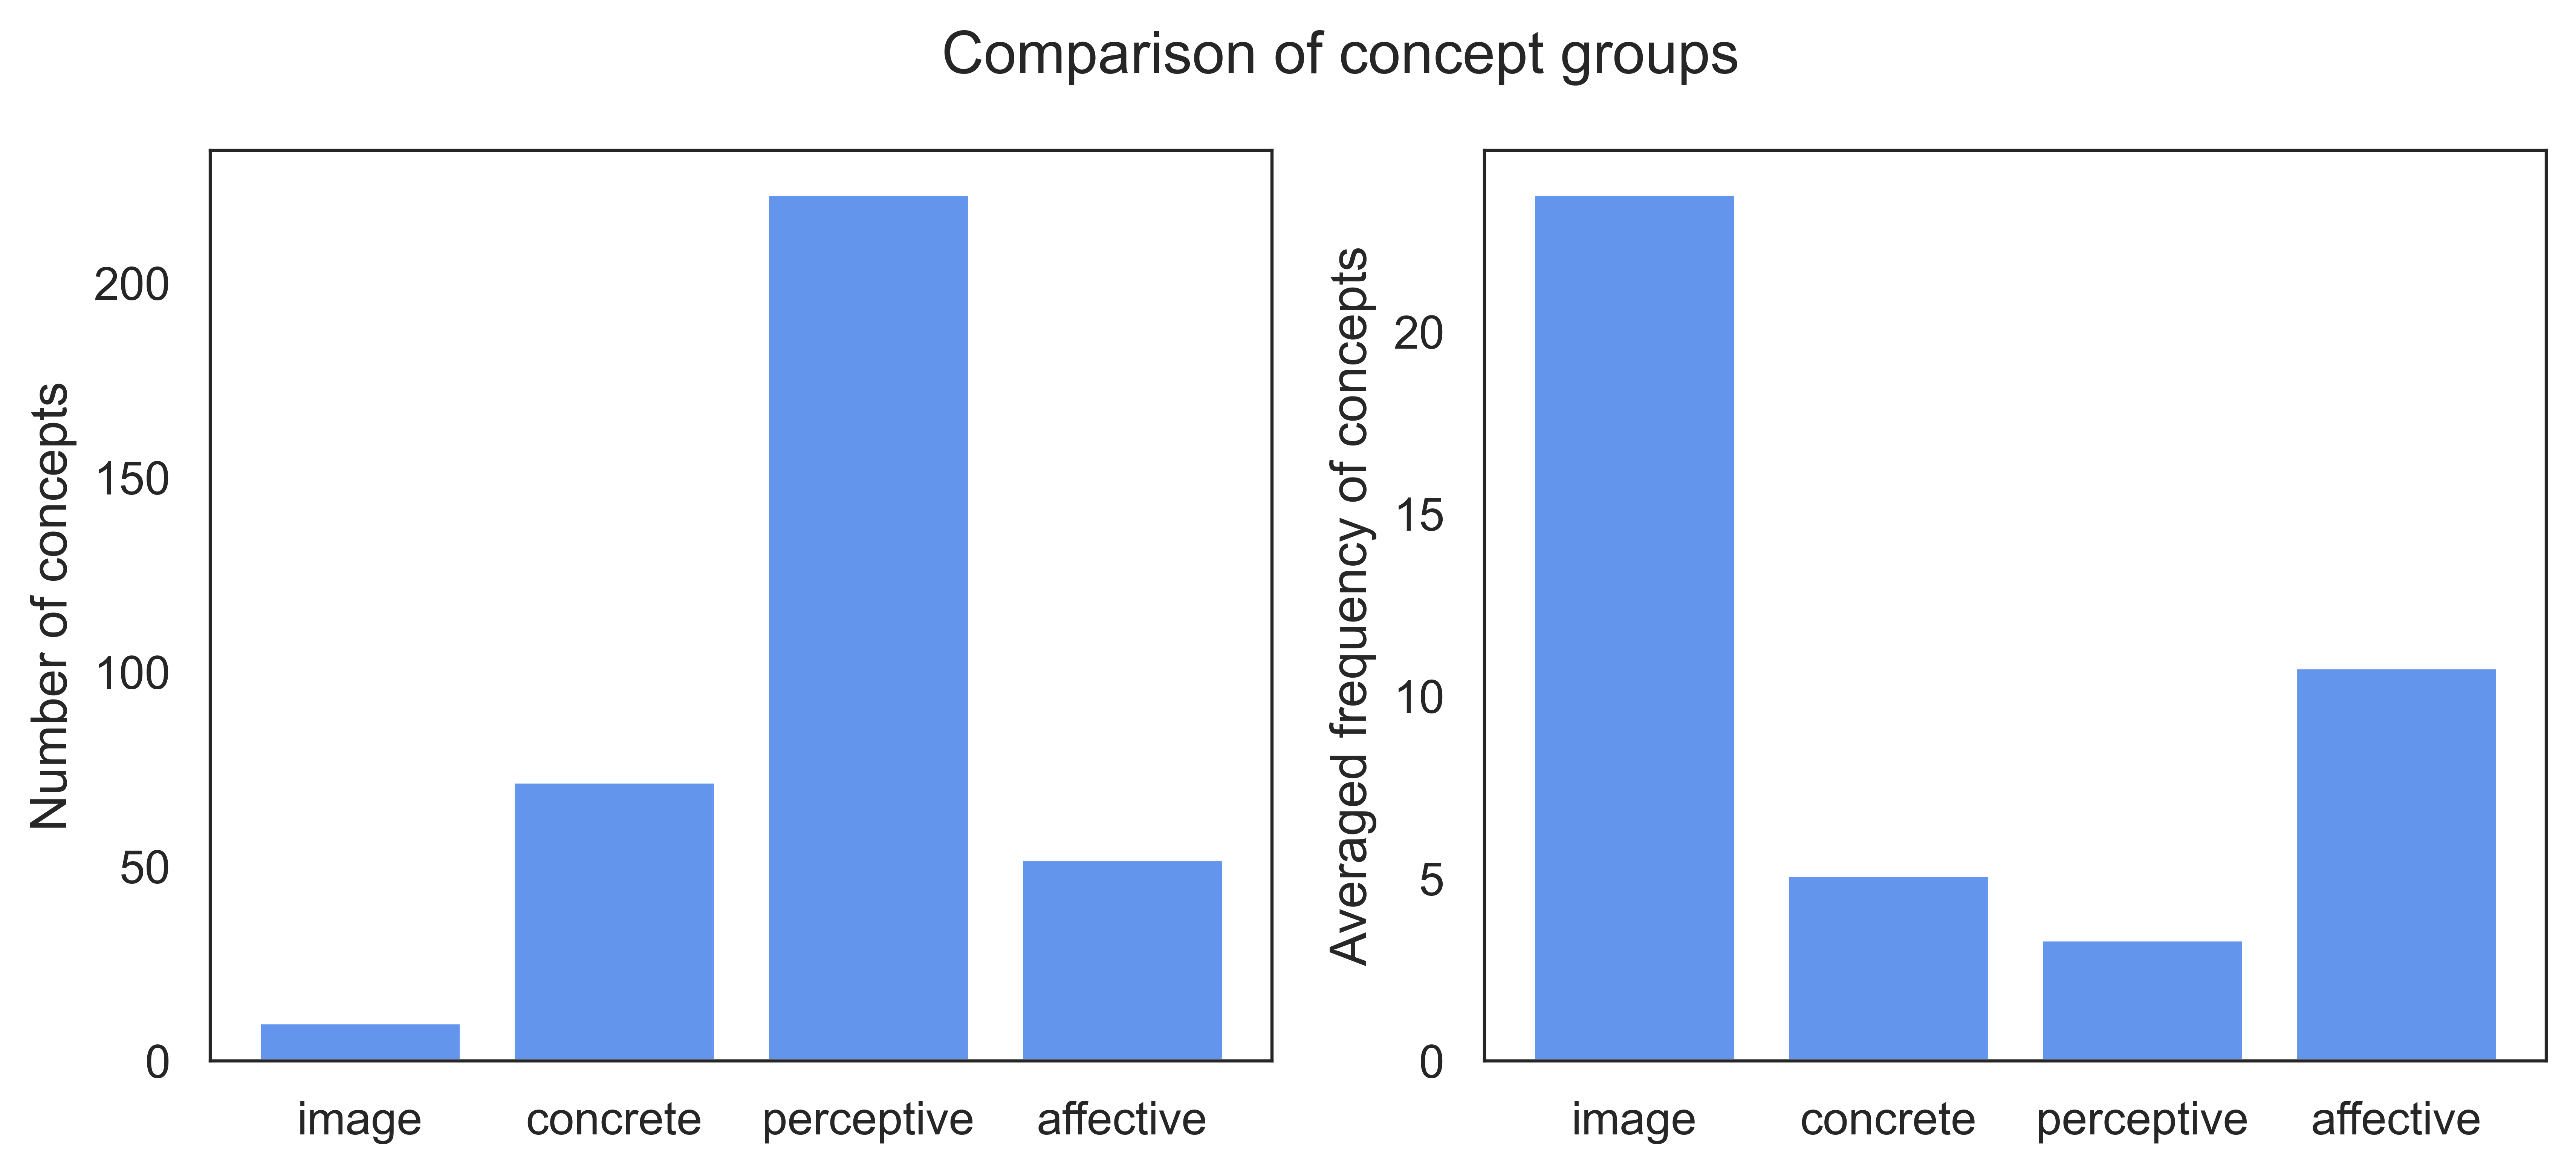

In [17]:
plt.rcParams['figure.dpi'] = 800
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 0.75
plt.rcParams["axes.facecolor"] = 'white'

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
fig.set_figheight(4)
plt.grid(False)
ax1.set_ylabel("Number of concepts")
fig.suptitle("Comparison of concept groups", size=14)
ax1.bar(x=["image", "concrete", "perceptive", "affective"],
        # ax1.bar(x=["old_concepts", "new_concepts"],
        height=list_of_counts,
        capsize=4, color='cornflowerblue')
plt.grid(False)
ax2.set_ylabel("Averaged frequency of concepts")
# ax2.set_ylim(0.63, 0.68)
ax2.bar(x=["image", "concrete", "perceptive", "affective"],
        # ax2.bar(x=["old_concepts", "new_concepts"],
        height=list_of_averaged_nums_of_one,
        capsize=4, color='cornflowerblue')


In [192]:
df_with_scores.columns

Index(['freq', 'text', 'concreteness_score', 'sentiment_score',
       'subjectivity_score', 'transformer_sentiment_score',
       'predicted_concept_label', 'true_concept_label'],
      dtype='object')

/Users/Cherry0904/Desktop/artemis/artemis/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/Cherry0904/Desktop/artemis/artemis/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/Cherry0904/Desktop/artemis/artemis/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

Text(330.0, 0.5, 'Density')

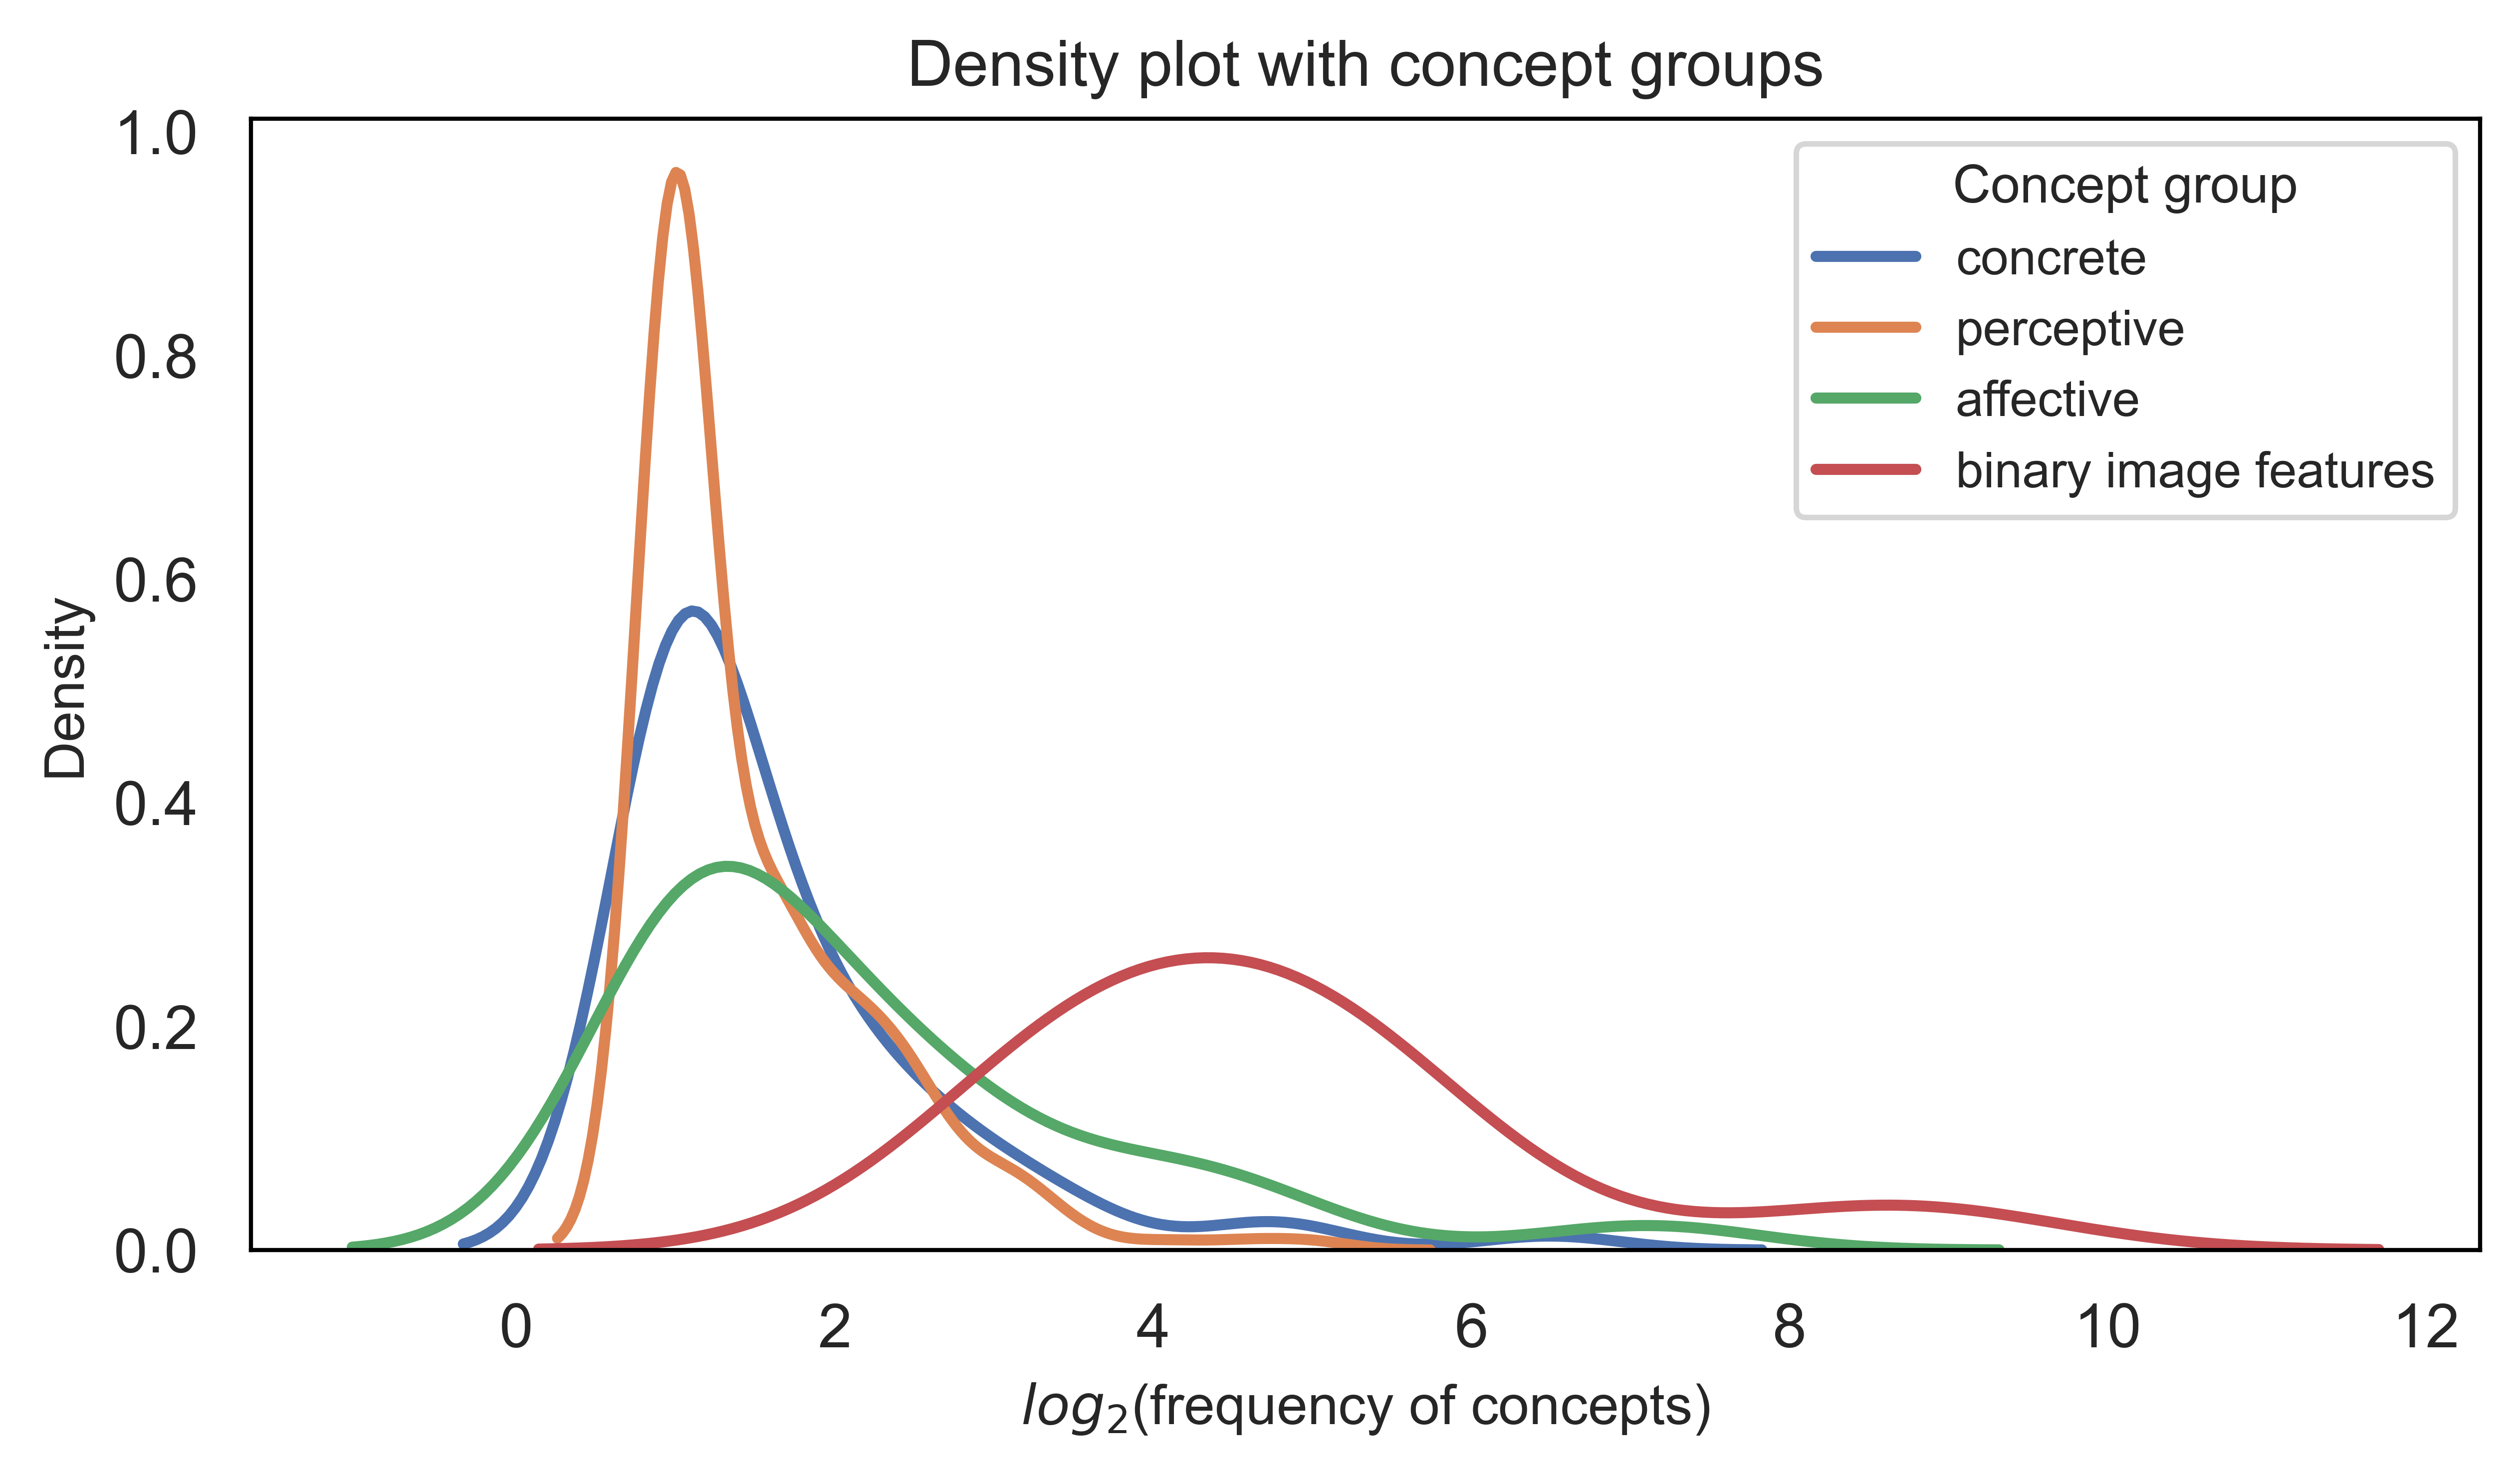

In [22]:
# List of three concept groups to plot
concept_groups = ['concrete', 'perceptive', 'affective']

plt.style.use('seaborn-whitegrid')
sns.set_style("ticks")
sns.set(rc={'figure.figsize': (6.5,3.7), "figure.dpi": 800, "axes.edgecolor": 'black', "axes.linewidth": 0.75, "axes.facecolor": 'white'})

# Iterate through the three concept groups"
for concept_group in concept_groups:
    # Subset to the airline
    subset = df_with_scores[df_with_scores['predicted_concept_label'] == concept_group]
    
    # Draw the density plot
    sns.distplot(np.log2(subset['freq']), hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = concept_group)

list_of_freq_img = [408, 48, 26, 15, 11, 34, 38, 22, 11, 9]
sns.distplot(np.log2(list_of_freq_img), hist = False, kde = True,
                 kde_kws = {'linewidth': 2},
                 label = 'binary image features')

# Plot formatting
# plt.figure(figsize=(8, 6), dpi=800)
plt.tight_layout()
plt.legend(prop={'size': 9}, title = 'Concept group', title_fontsize=9.5, frameon=True)
plt.title('Density plot with concept groups', size=11.5)
plt.xlabel(r'$log_{2}$(frequency of concepts)', size=10)
plt.ylabel('Density', size=10)

In [147]:
df_with_true_label = pd.read_csv('/Users/Cherry0904/Desktop/subset_2000_concepts_with_labels.csv')
df_with_true_label.columns

Index(['Unnamed: 0', 'freq', 'text', 'predicted_concept_label',
       'true_concept_label'],
      dtype='object')

In [148]:
from sklearn.metrics import classification_report
y_true = df_with_true_label['true_concept_label']
y_pred = df_with_true_label['predicted_concept_label']
target_names = ['concrete', 'perceptive', 'affective']
print(classification_report(y_true, y_pred, target_names = target_names))

              precision    recall  f1-score   support

    concrete       0.77      0.94      0.85        36
  perceptive       0.82      0.70      0.76        67
   affective       0.89      0.90      0.89       148

    accuracy                           0.85       251
   macro avg       0.83      0.85      0.83       251
weighted avg       0.85      0.85      0.85       251



In [ ]:
# Create an array indicating the concept label - use in correspond with the concept matrix later
concept_label_array = df_with_scores[['predicted_concept_label']].to_numpy()
print(concept_label_array)

##### Clustering based on word embeddings

In [57]:
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def cluster_text(text):
    vectorizer = TfidfVectorizer(stop_words={'english'}) # TF-IDF vectorisation
    X = vectorizer.fit_transform(text)

    Sum_of_squared_distances = []
    K = range(2,10)
    for k in K:
       km = KMeans(n_df_dominant_topic=k, max_iter=200, n_init=10)
       km = km.fit(X)
       Sum_of_squared_distances.append(km.inertia_)
       
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    print('How many df_dominant_topic do you want to use?')
    true_k = 3 # 4
    model = KMeans(n_df_dominant_topic=true_k, init='k-means++', max_iter=200, n_init=10)
    model.fit(X)

    labels=model.labels_
    df_dominant_topic=pd.DataFrame(list(zip(text,labels)),columns=['title','cluster'])
    #print(clusters.sort_values(by=['cluster']))

    for i in range(true_k):
        print(clusters[clusters['cluster'] == i])
        
    return clusters

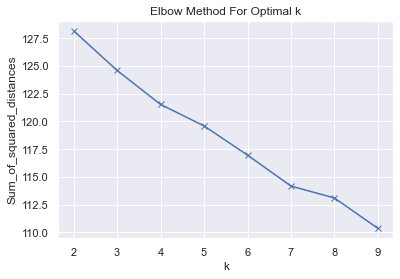

How many clusters do you want to use?
                                                 title  cluster
4     the colors are beautiful and calming peaceful...        0
5                                       her look upset        0
6                         the colors aren't attractive        0
7     the light in the painting brings a sense of p...        0
13                                     she seems happy        0
14                                   the woman's dress        0
15      this one looks pretty boring and unspectacular        0
16                             the colors used in this        0
17                      the flowers are bright colours        0
18                              had a child drawn them        0
21                       what is going in the painting        0
22                                 they were not happy        0
23                                    the woman's face        0
25                                      the man's face        0
26

In [59]:
# Clustering separates well the concepts that contain "me, I", but not between perfectly concrete and perceptive concepts
list_of_concepts = df.text.tolist()
clusters = cluster_text(list_of_concepts)


##### Topic Modelling

In [51]:
# Topic modelling using LDA
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [52]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['me', 'feel', 'sad']]


In [53]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [55]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.063*"color" + 0.045*"calm" + 0.041*"blue" + 0.034*"dark" + 0.033*"sky" + '
  '0.033*"water" + 0.032*"people" + 0.031*"paint" + 0.025*"painting" + '
  '0.024*"contrast"'),
 (1,
  '0.111*"look" + 0.101*"feel" + 0.045*"flower" + 0.033*"love" + 0.031*"sky" + '
  '0.024*"bright" + 0.020*"contentment" + 0.020*"create" + '
  '0.020*"peacefulness" + 0.020*"sad"'),
 (2,
  '0.095*"woman" + 0.071*"face" + 0.037*"amazing" + 0.025*"baby" + '
  '0.024*"dress" + 0.022*"hold" + 0.022*"lady" + 0.019*"remind" + '
  '0.018*"splash" + 0.018*"wave"')]


In [56]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(40)

/var/folders/6f/6ngp6cds4hq9z7fnmw29_d2m0000gn/T/ipykernel_59259/3547581473.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/6f/6ngp6cds4hq9z7fnmw29_d2m0000gn/T/ipykernel_59259/3547581473.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1,0.7775,"look, feel, flower, love, sky, bright, content...","[feel, sad]"
1,1,1,0.4462,"look, feel, flower, love, sky, bright, content...","[feel, calm]"
2,2,1,0.7719,"look, feel, flower, love, sky, bright, content...","[feel, excited]"
3,3,2,0.6483,"woman, face, amazing, baby, dress, hold, lady,...",[laugh]
4,4,0,0.9045,"color, calm, blue, dark, sky, water, people, p...","[color, beautiful, calm, peaceful, beautiful, ..."
5,5,1,0.7719,"look, feel, flower, love, sky, bright, content...","[look, upset]"
6,6,0,0.7706,"color, calm, blue, dark, sky, water, people, p...","[color, attractive]"
7,7,0,0.8846,"color, calm, blue, dark, sky, water, people, p...","[light, painting, bring, sense, peace]"
8,8,1,0.7719,"look, feel, flower, love, sky, bright, content...","[feel, scared]"
9,9,1,0.7719,"look, feel, flower, love, sky, bright, content...","[feel, awe]"


In [61]:
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 0, 'Dominant_Topic'] = 'perceptive'
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 1, 'Dominant_Topic'] = 'affective'
df_dominant_topic.loc[df_dominant_topic['Dominant_Topic'] == 2, 'Dominant_Topic'] = 'concrete'

from sklearn.metrics import classification_report
y_true = df_with_true_label['true_concept_label']
y_pred = df_dominant_topic['Dominant_Topic']
target_names = ['concrete', 'perceptive', 'affective']
print(classification_report(y_true, y_pred, target_names = target_names))

              precision    recall  f1-score   support

    concrete       0.45      0.75      0.56        32
  perceptive       0.55      0.58      0.56        38
   affective       0.68      0.46      0.55        70

    accuracy                           0.56       140
   macro avg       0.56      0.60      0.56       140
weighted avg       0.59      0.56      0.56       140



In [182]:
import pyLDAvis.gensim
# from IPython.core.display import display, HTML

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
pyLDAvis.display(vis) 

[autoreload of pyLDAvis._prepare failed: Traceback (most recent call last):
  File "/Users/Cherry0904/Desktop/artemis/artemis/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/Cherry0904/Desktop/artemis/artemis/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 480, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/Cherry0904/Desktop/artemis/artemis/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 377, in update_generic
    update(a, b)
  File "/Users/Cherry0904/Desktop/artemis/artemis/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 345, in update_class
    update_instances(old, new)
  File "/Users/Cherry0904/Desktop/artemis/artemis/lib/python3.8/site-packages/IPython/extensions/autoreload.py", line 303, in update_instances
    ref.__class__ = new
TypeError: __class__ assignment: 'PreparedData' object layout differs from 'P

In [168]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0,0.9045,"color, calm, blue, dark, sky, water, people, paint, painting, contrast","[color, beautiful, calm, peaceful, beautiful, scene]"
1,1,0.9155,"look, feel, flower, love, sky, bright, contentment, create, peacefulness, sad","[flower, bright, sky, create, feel, peacefulness, contentment]"
2,2,0.8885,"woman, face, amazing, baby, dress, hold, lady, remind, splash, wave","[woman, dress, elegant, white, dress]"


#### Word clouds of extracted concepts

/Users/Cherry0904/Desktop/artemis/artemis/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Cherry0904/Desktop/artemis/artemis/lib/python3.8/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/Cherry0904/Desktop/artemis/artemis/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/Cherry0904/Desktop/artemis/artemis/lib/python3.8/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be remove

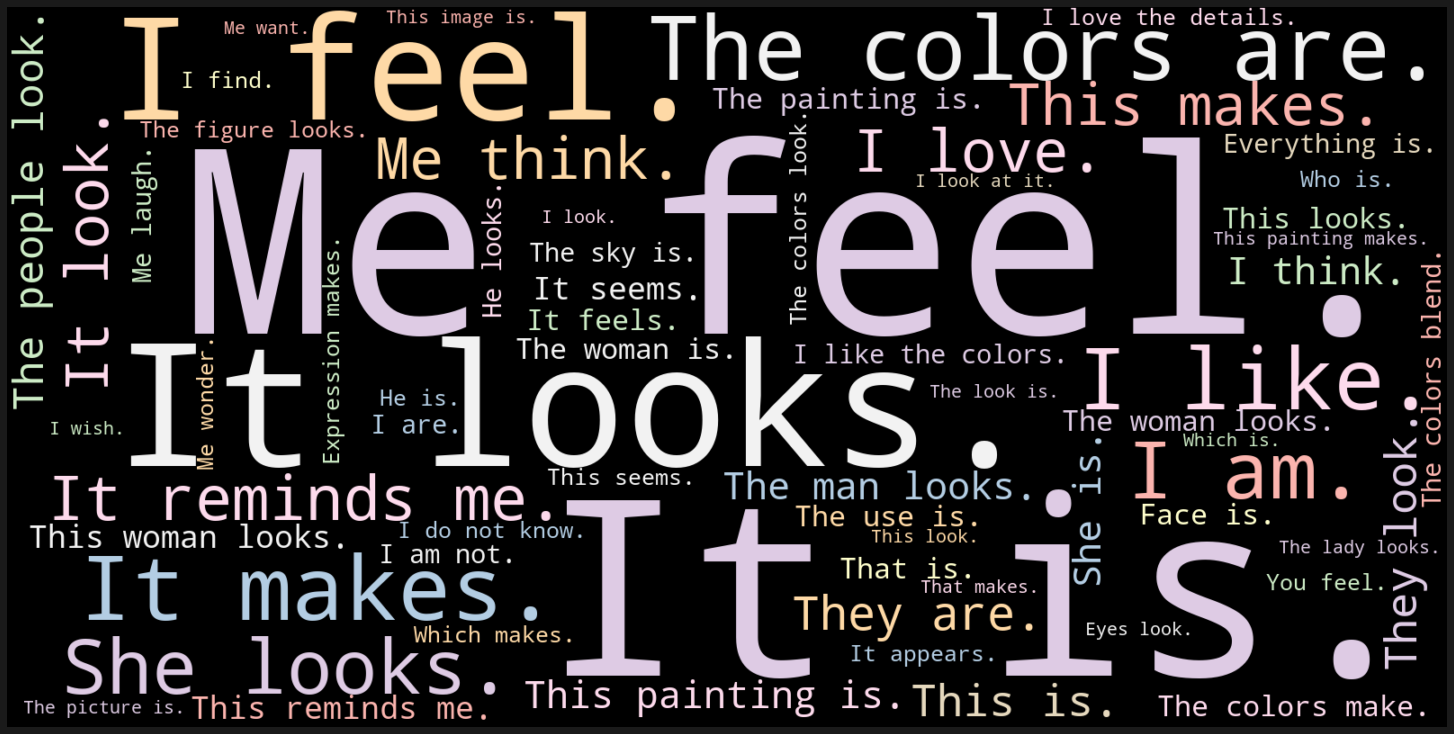

In [251]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800, collocations=False, colormap = 'Pastel1')
wordcloud.generate_from_frequencies(frequencies=d)

plt.figure(figsize=(20,10), facecolor='k')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [230]:
df = pd.DataFrame(data, columns=['emotion', 'utterance'])
print(df)
df.to_csv('/Users/Cherry0904/Desktop/20_examples_3_cols.csv', sep=',', encoding='utf-8')

           emotion  \
0             fear   
1       excitement   
2      contentment   
3   something else   
4        amusement   
5      contentment   
6      contentment   
7   something else   
8        amusement   
9          sadness   
10     contentment   
11       amusement   
12             awe   
13     contentment   
14             awe   
15         disgust   
16     contentment   
17             awe   
18             awe   
19         sadness   

                                                                                                                                                                                                                                   utterance  
0                                                                                                                                                      the soldier who is at war has a target in his scope and he is ready to shoot his gun.  
1                                                          